## Documentation
Requirements:

get keras-segmentation with 'pip install keras-segmentation'. Refer to documentation https://github.com/divamgupta/image-segmentation-keras

Useful tutorials:

https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html


Directory structure:
TODO

### Handseg dataset:
Width: 640, Height: 480. The annotated images contain three classes: background: 0, right_hand: 1, left_hand: 2.

Accessing the data:

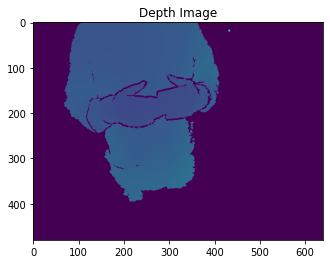

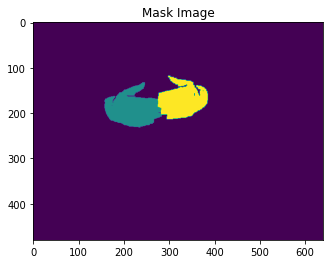

1


In [18]:
#path to the dataset
handseg_path = '../../handseg-150k'
depth_im = np.array(Image.open(Path(handseg_path+'/images/user-2.00000000.png')))# Loading depth image
mask_im = np.array(Image.open(Path(handseg_path+'/masks/user-2.00000000.png')))#  Loading mask image
depth_im = depth_im.astype(np.float32)# Converting to float
mean_depth_ims = 10000.0 # Mean value of the depth images
depth_im /= mean_depth_ims # Normalizing depth image
plt.imshow(depth_im); plt.title('Depth Image'); plt.show() # Displaying Depth Image
plt.imshow(mask_im); plt.title('Mask Image'); plt.show() # Displaying Mask Image

print(mask_im[200,200])

In [1]:
#Library header
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras import Model, Input
from keras_segmentation.predict import predict
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, LeakyReLU, Add, Conv2DTranspose, Dense, concatenate
from keras_segmentation.models.model_utils import get_segmentation_model
import shutil #library for moving files
import tensorflow as tf
import numpy as np


#load predefined model, like segnet with:
from keras_segmentation.models.segnet import segnet #vanilla segnet

#globals
input_width = 640
input_height = 480
handseg_path = '../../../handseg-150k'

In [21]:
# created own model based on the proposed model in HandSeg

# three classes: background: 0, right_hand: 1, left_hand: 2
def handseg_model(input_layer, num_classes):
  # use stride_val for projection_shortcut
  stride_val = 2
  
  # decode part ================================================================
  # first layer
  conv2d_1 = Conv2D(64, 3, strides=stride_val, padding='same', data_format='channels_last')(input_layer)
  leaky_relu_1 = LeakyReLU()(conv2d_1)

  # second layer
  conv2d_2 = Conv2D(128, 3, strides=stride_val, padding='same', data_format='channels_last')(leaky_relu_1)
  bn_2 = BatchNormalization()(conv2d_2)
  leaky_relu_2 = LeakyReLU()(bn_2)

  # third layer
  conv2d_3 = Conv2D(256, 3, strides=stride_val, padding='same', data_format='channels_last')(leaky_relu_2)
  bn_3 = BatchNormalization()(conv2d_3)
  leaky_relu_3 = LeakyReLU()(bn_3)

  # fourth layer
  conv2d_4 = Conv2D(512, 3, strides=stride_val, padding='same', data_format='channels_last')(leaky_relu_3)
  bn_4 = BatchNormalization()(conv2d_4)
  leaky_relu_4 = LeakyReLU()(bn_4)

  # encode part ================================================================
  # first layer
  # do the skip connection
  skip = Conv2DTranspose(256, 3, strides=stride_val, padding='same', data_format='channels_last')(leaky_relu_4)
  encode_input_1 = concatenate([leaky_relu_3, skip], axis=-1)
  encode_bn_1 = BatchNormalization()(encode_input_1)
  encode_relu_1 = ReLU()(encode_bn_1)
      
  # second layer
  # do the skip connection
  skip = Conv2DTranspose(128, 3, strides=stride_val, padding='same', data_format='channels_last')(encode_relu_1)
  encode_input_2 = concatenate([leaky_relu_2, skip], axis=-1)
  encode_bn_2 = BatchNormalization()(encode_input_2)
  encode_relu_2 = ReLU()(encode_bn_2)

  # third layer
  # do the skip connection
  skip = Conv2DTranspose(64, 3, strides=stride_val, padding='same', data_format='channels_last')(encode_relu_2)
  encode_input_3 = concatenate([leaky_relu_1, skip], axis=-1)
  encode_bn_3 = BatchNormalization()(encode_input_3)
  encode_relu_3 = ReLU()(encode_bn_3)

  # last layer
  last_layer = Conv2DTranspose(1, 3, strides=stride_val, padding='same', data_format='channels_last')(encode_relu_3)

  output = Conv2D(num_classes, 1, padding='same', data_format = 'channels_last')(last_layer)
  #output = Dense(num_classes, activation='softmax')(last_layer)
  return output

In [2]:
inputs = Input(shape=(480, 640, 3))
outputs = handseg_model(input_layer=inputs, num_classes=3)

# build the segmentation model
handseg_model = get_segmentation_model(inputs, outputs)

Verifying training dataset


KeyboardInterrupt: 

In [ ]:
# training
# ignore zero class -> masked categorical cross entropy, else categorical cross entropy
handseg_model.train( 
    train_images=handseg_path+"/images/",
    train_annotations=handseg_path+"/masks/",
    input_height=480,
    input_width=640,
    val_images=handseg_path+"/val_images",
    val_annotations=handseg_path+"/val_masks",
    n_classes=3,
    validate=True,
    batch_size=8,
    val_batch_size=8,
    do_augment=True,
    optimizer_name="adam",
    checkpoints_path="./checkpoints/handseg",
    epochs=5)


# evaluation
print(handseg_model.evaluate_segmentation(inp_images_dir=handseg_path+'/test_images',
                                         annotations_dir=handseg_path+'/test_masks'))

# prediction, can also be applied on a whole directory
out = handseg_model.predict_segmentation(
    inp= handseg_path+"/predict/depth_1_0000045.png",
    out_fname= handseg_path+"/predict/predictedOutput.png"
)

#visualization
plt.imshow(out)